In [28]:
#Importing libraries required for this project
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline

In [56]:
#Load data from csv file to a data frame
ship_fuel_df = pd.read_csv("ship_fuel_efficiency.csv")
#print out the first 5 rows and all the columns
ship_fuel_df.head()

,ship_id,ship_type,route_id,month,distance,fuel_type,fuel_consumption,CO2_emissions,weather_conditions,engine_efficiency
0,NG001,Oil Service Boat,Warri-Bonny,January,132.26,HFO,3779.77,10625.76,Stormy,92.14
1,NG001,Oil Service Boat,Port Harcourt-Lagos,February,128.52,HFO,4461.44,12779.73,Moderate,92.98
2,NG001,Oil Service Boat,Port Harcourt-Lagos,March,67.30,HFO,1867.73,5353.01,Calm,87.61
3,NG001,Oil Service Boat,Port Harcourt-Lagos,April,71.68,Diesel,2393.51,6506.52,Stormy,87.42
4,NG001,Oil Service Boat,Lagos-Apapa,May,134.32,HFO,4267.19,11617.03,Calm,85.61


In [57]:
#Check for Nulls
print(pd.isnull(ship_fuel_df).sum())

ship_id               0
ship_type             0
route_id              0
month                 0
distance              0
fuel_type             0
fuel_consumption      0
CO2_emissions         0
weather_conditions    0
engine_efficiency     0
dtype: int64


In [58]:
#Data Cleaning
#Dropping ship_id since this is not required for the data analysis of this project
ship_fuel_df = ship_fuel_df.drop(columns=['ship_id'])
ship_fuel_df.head()

,ship_type,route_id,month,distance,fuel_type,fuel_consumption,CO2_emissions,weather_conditions,engine_efficiency
0,Oil Service Boat,Warri-Bonny,January,132.26,HFO,3779.77,10625.76,Stormy,92.14
1,Oil Service Boat,Port Harcourt-Lagos,February,128.52,HFO,4461.44,12779.73,Moderate,92.98
2,Oil Service Boat,Port Harcourt-Lagos,March,67.30,HFO,1867.73,5353.01,Calm,87.61
3,Oil Service Boat,Port Harcourt-Lagos,April,71.68,Diesel,2393.51,6506.52,Stormy,87.42
4,Oil Service Boat,Lagos-Apapa,May,134.32,HFO,4267.19,11617.03,Calm,85.61


In [ ]:
"""#One hot encoding for categorial variables (ship_type, route_id, month, fuel_type, weather_conditions)
#Scaling for numerical variables
#Separate the data into inputs (X) and output (y) 
X = ship_fuel_df.drop('CO2_emissions', axis=1)
y = ship_fuel_df['CO2_emissions']

#Make a list for each variable type (Categorical and Numerical)
catcolumn = ['ship_type','route_id', 'month', 'fuel_type', 'weather_conditions']
numcolumn = ['distance', 'fuel_consumption', 'engine_efficiency']

#Creation of a column tranformer to scale numerical values and one hot endode the categorial values
transformer = ColumnTransformer(transformers=[("num", MinMaxScaler(), numcolumn), ('cat', OneHotEncoder(drop='first',sparse_output=False), catcolumn)])

#Using the transformer to apply scaling and one hot encoding in one shot (the type changes to numpy from pandas df)
X_np = transformer.fit_transform(X)

num_cols_transformed = numcolumn

# Getting categorical feature names after one-hot encoding
cat_cols_transformed = transformer.named_transformers_['cat'].get_feature_names_out(catcolumn)

# Combine both sets of columns
all_cols = np.concatenate([num_cols_transformed, cat_cols_transformed])

# Convert numpy array back to DataFrame WITH column names
X_df = pd.DataFrame(X_np, columns=all_cols)"""

In [59]:
#Split the inputs and output
X = ship_fuel_df.drop('CO2_emissions', axis=1)
y = ship_fuel_df['CO2_emissions']

#List of categorical columns
catcolumn = ['ship_type','route_id', 'month', 'fuel_type', 'weather_conditions']
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
encoder = OneHotEncoder(sparse_output=False)

one_hot_encoded = encoder.fit_transform(X[catcolumn])

one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(catcolumn))

df_encoded = pd.concat([X, one_hot_df], axis=1)

df_encoded = df_encoded.drop(categorical_columns, axis=1)

df_encoded.to_csv('encoded_dataframe.csv', index=False)

In [60]:
df_encoded.head()

,distance,fuel_consumption,engine_efficiency,ship_type_Fishing Trawler,ship_type_Oil Service Boat,ship_type_Surfer Boat,ship_type_Tanker Ship,route_id_Escravos-Lagos,route_id_Lagos-Apapa,route_id_Port Harcourt-Lagos,...,month_March,month_May,month_November,month_October,month_September,fuel_type_Diesel,fuel_type_HFO,weather_conditions_Calm,weather_conditions_Moderate,weather_conditions_Stormy
0,132.26,3779.77,92.14,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,128.52,4461.44,92.98,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,67.30,1867.73,87.61,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,71.68,2393.51,87.42,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,134.32,4267.19,85.61,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [67]:
#Split the data into train and test set (7:3)
X_train, X_test, y_train, y_test = train_test_split(df_encoded, y, test_size=0.2, random_state=42)
print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)

Shape of X_train:  (1152, 28)
Shape of X_test:  (288, 28)


In [68]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [69]:
#Linear Regression
LinearModel = LinearRegression()
LinearModel.fit(X_train, y_train)
y_pred = LinearModel.predict(X_test)

#Calculation of R^2, MSE, MAE
Lr2 = r2_score(y_test, y_pred)
Lmse = mean_squared_error(y_test, y_pred)
Lmae = mean_absolute_error(y_test, y_pred)

print(f"r2: {Lr2}, mse: {Lmse}, mae: {Lmae}")

r2: 0.9949733568275332, mse: 1043894.1939721158, mae: 633.9750202880542


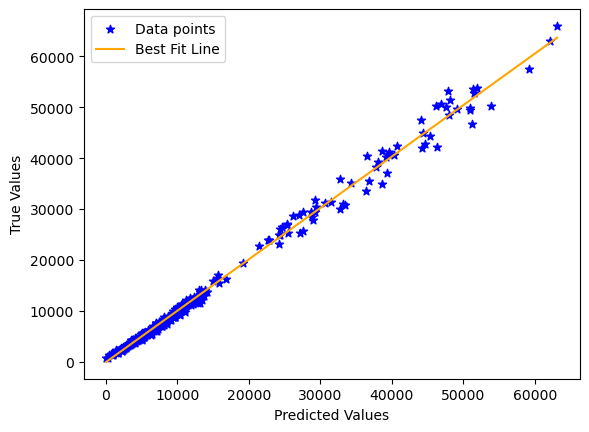

In [75]:
# Example scatter plot using predicted and actual values
plt.scatter(y_pred, y_test, marker='*', color='blue', label='Data points')

# Compute the best fit line parameters (slope and intercept)
slope, intercept = np.polyfit(y_pred, y_test, 1)

# Create x values for plotting the line. Here, we create 100 equally spaced values between the min and max of y_pred.
x_line = np.linspace(np.min(y_pred), np.max(y_pred), 100)
y_line = slope * x_line + intercept

# Plot the best fit line
plt.plot(x_line, y_line, color='orange', label='Best Fit Line')

# Add labels, legend, and show the plot
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.legend()
plt.show()

In [71]:
#Generatng alpha from 0 to 10 in steps of 0.001
alpha = np.arange(0,10.001,0.001)
alpha = alpha.tolist()
results = {}
#for loop to test out all the alpha values to find the best value
for a in alpha:
    #Ridge Regression
    RidgeModel = Ridge(alpha=a)
    RidgeModel.fit(X_train, y_train)
    y_pred = RidgeModel.predict(X_test)

    #Calculation of R^2, MSE, MAE
    Rr2 = r2_score(y_test, y_pred)
    Rmse = mean_squared_error(y_test, y_pred)
    Rmae = mean_absolute_error(y_test, y_pred)

    results[a] = {'R2': Rr2, 'MSE': Rmse, 'MAE': Rmae}

#Output the best performing alpha and its performance matrics 
best_alpha_val = max(results, key=lambda a: results[a]['R2'])
print("Best alpha: ", best_alpha_val)
print("Performance for best alpha: ", results[best_alpha_val])

Best alpha:  0.001
Performance for best alpha:  {'R2': 0.9949762298570884, 'MSE': 1043297.5455192839, 'MAE': 633.7118401829564}


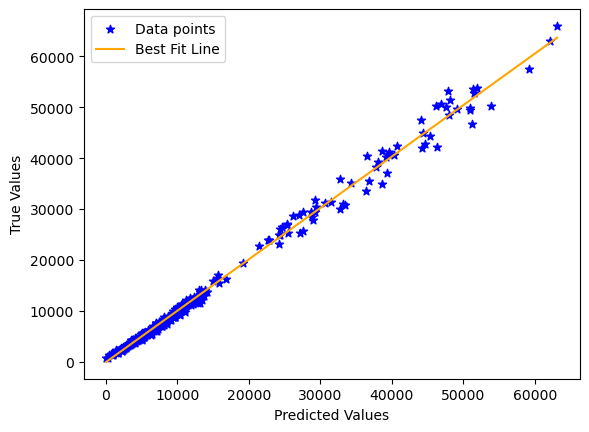

In [74]:
# Example scatter plot using predicted and actual values
plt.scatter(y_pred, y_test, marker='*', color='blue', label='Data points')

# Compute the best fit line parameters (slope and intercept)
slope, intercept = np.polyfit(y_pred, y_test, 1)

# Create x values for plotting the line. Here, we create 100 equally spaced values between the min and max of y_pred.
x_line = np.linspace(np.min(y_pred), np.max(y_pred), 100)
y_line = slope * x_line + intercept

# Plot the best fit line
plt.plot(x_line, y_line, color='orange', label='Best Fit Line')

# Add labels, legend, and show the plot
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.legend()
plt.show()

In [79]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Using cross_val_score with r² as the metric
lr_scores = cross_val_score(LinearModel, df_encoded, y, cv=kf, scoring='r2')
print("Linear Regression CV R² scores:", lr_scores)
print("Mean CV R² (Linear Regression):", lr_scores.mean())

# --- Ridge Regression Evaluation ---
# You can experiment with different alpha values.
ridge_alpha = 0.001
RidgeModel = Ridge(alpha=ridge_alpha)
ridge_scores = cross_val_score(RidgeModel, df_encoded, y, cv=kf, scoring='r2')
print(f"Ridge Regression (alpha={ridge_alpha}) CV R² scores:", ridge_scores)
print(f"Mean CV R² (Ridge Regression):", ridge_scores.mean())

Linear Regression CV R² scores: [0.99497629 0.99455004 0.9944108  0.99468615 0.99307483]
Mean CV R² (Linear Regression): 0.9943396227097873
Ridge Regression (alpha=0.001) CV R² scores: [0.99497629 0.99455004 0.9944108  0.99468616 0.99307483]
Mean CV R² (Ridge Regression): 0.9943396241298735
